In [1]:
import sys, os
everestPath = os.path.abspath('everest')
if not everestPath in sys.path:
    sys.path.insert(0, everestPath)

In [2]:
from functools import reduce
import operator
import math
import numpy as np
import scipy as sp
import pandas as pd
import sklearn

In [3]:
from everest.h5anchor import Reader, Fetch
F = lambda key: Fetch(f"*/{key}")

In [4]:
reader = Reader('obsvisc', '.')
merged = Reader('merged', '.')

In [5]:
from everest.window import Canvas
from matplotlib.pyplot import get_cmap
%matplotlib inline

In [6]:
paramKeys = ('f', 'aspect', 'tauRef', 'temperatureField')
params = dict()
for key in paramKeys:
    params[key] = sorted(set(reader[f"*/{key}"].values()))

In [7]:
tauLogs = tuple(math.log10(tau) for tau in params['tauRef'])
minTau, maxTau = min(tauLogs), max(tauLogs)
normTau = lambda tau: (math.log10(tau) - minTau) / (maxTau - minTau)

In [8]:
sinuKeys = ('_built_peaskauslu-thoesfthuec', '_built_oiskeaosle-woatihoo')
sinuFetches = tuple(F('temperatureField') == k for k in sinuKeys)
copyKeys = tuple(
    k for k in params['temperatureField']
        if not k in sinuKeys
    )
copyFetches = tuple(F('temperatureField') == k for k in copyKeys)

sinuModels = reader[reduce(operator.__or__, sinuFetches)]
copyModels = reader[reduce(operator.__or__, copyFetches)]

In [9]:
cut = reader[(F('f') == 1.) & (F('aspect') == 1.)] & sinuModels
keys = ('t', 'Nu', 'tauRef', 'f', 'aspect')
datas = reader[cut : keys]
ts, Nus, taus, fs, aspects = zip(*datas.values())

cmap = get_cmap('viridis')
canvas = Canvas(size = (12, 3))
ax = canvas.make_ax()
for t, Nu, tauRef, f, aspect in datas.values():
    ax.line(t, Nu, c = cmap(normTau(tauRef)))

In [10]:
ax.axes.x.label = 'Dimensionless time'
ax.axes.y.label = 'Nusselt number'

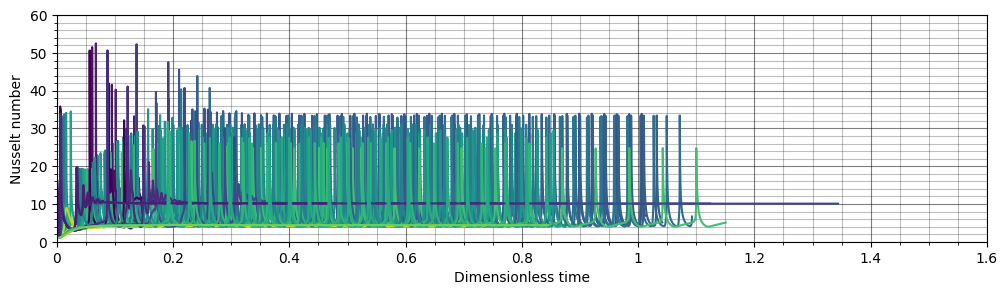

In [11]:
canvas.show()

In [12]:
cut = \
    reader[F('aspect') < 3] \
    & reader[F('temperatureField') == '_built_peaskauslu-thoesfthuec']

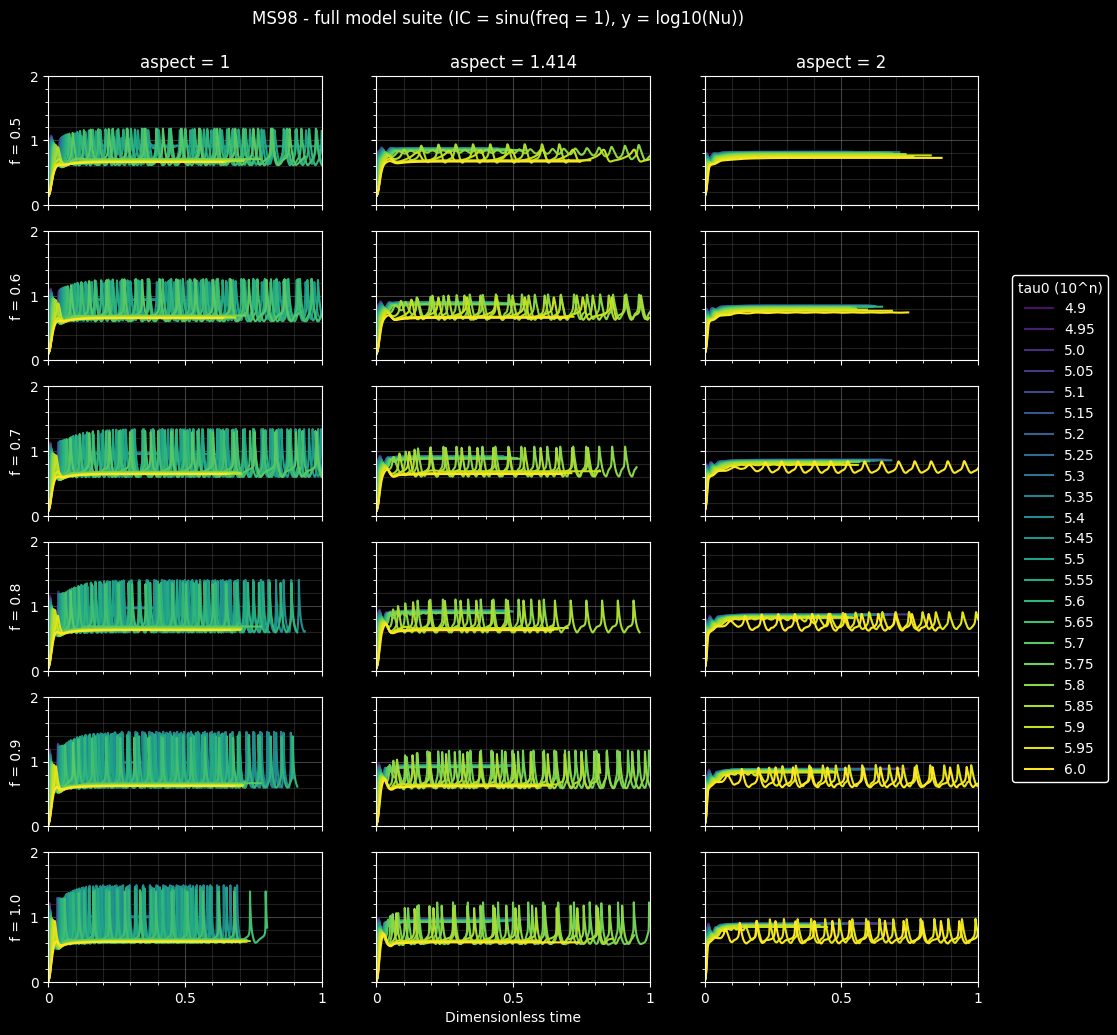

In [47]:
from everest.window.data import Data
canvas = Canvas(
    name = 'MS98plot',
#     title = 'MS98 - full model suite (IC = sinu(freq = 2), y = log10(Nu))',
#     dpi = 300,
    shape = (6, 3),
    size = (12, 12),
    facecolour = 'black',
    )
cmap = get_cmap('viridis')
alltaus = []
for col, aspect in enumerate((1, 1.414, 2)):
    for row, f in enumerate((0.5, 0.6, 0.7, 0.8, 0.9, 1.0)):
        ax = canvas.make_ax((row, col))
        subcut = cut & reader[F('f') == f] & reader[F('aspect') == aspect]
        datas = reader[subcut : ('t', 'Nu', 'tauRef')]
        vals = sorted(datas.values(), key = lambda d: d[-1])
        for t, Nu, tauRef in vals:
            alltaus.append(math.log10(tauRef))
            ax.line(
                Data(t, lims = (0, 1), capped = (True, True)),
                Data(np.log10(Nu), lims = (0, 2), capped = (True, True)),
                c = cmap(normTau(tauRef))
                )
#         ax.axes.y.swap()
        if row == 0: ax.axes.title = f"aspect = {aspect}"
        if col == 0: ax.axes.y.label = f"f = {f}"
        if row != 5:
            ax.ticks.x.major.labels = []
        if col != 0:
            ax.ticks.y.major.labels = []
        ax.axes.colour = 'white'
        ax.grid.colour = 'grey'
        ax.ticks.colour = 'white'
canvas.axs[-1][1][0].axes.x.label = 'Dimensionless time'
# canvas.axs[0][2][0].axes.y.label = 'Nusselt number (log10)'

alltaus = sorted(set(alltaus))

ax = canvas.axs[0][-1][0]
legendValues = alltaus
legendHandles = [r[0] for r in ax.collections]
legendLabels = [str(v) for v in legendValues]
handles, labels, _ = zip(*sorted(zip(legendHandles, legendLabels, legendValues), key = lambda r: r[-1]))
legend = ax.ax.legend(
    handles,
    labels,
    loc = 'right',
    framealpha = 1.,
    labelcolor = 'white',
    title = 'tau0 (10^n)',
    frameon = True,
    facecolor = 'black',
    bbox_to_anchor = (1.5, -2.5),
    )
legend.properties()['title'].set_color('white')
legend.get_frame().set_edgecolor('w')

title = canvas.fig.suptitle(
    'MS98 - full model suite (IC = sinu(freq = 1), y = log10(Nu))',
    c = 'white',
    y = 0.935,
    )

canvas.show()

In [ ]:
canvas.axs[0][0][0].ticks.